In [29]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

import keras
from keras import layers,ops
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
num_classes = 2
input_shape = (224,224, 3)

In [17]:
import pickle
with open("Features/img_data.pkl", "rb") as f:
    image_data = pickle.load(f)
with open ("Features/labels.pkl","rb") as f:
    labels = pickle.load(f)

In [27]:
first_500_images = image_data[:1500]
last_500_images = image_data[-1500:]
images_subset = np.concatenate([first_500_images,last_500_images],axis = 0)

first_500_labels = labels[:1500]
last_500_labels = labels[-1500:]
labels_subset = np.concatenate([first_500_labels,last_500_labels],axis = 0)
images_subset.shape, labels_subset.shape

((3000, 224, 224, 3), (3000,))

In [33]:
x_train, x_val, y_train, y_val = train_test_split(images_subset,labels_subset,test_size = 0.3)
x_train.shape

(2100, 224, 224, 3)

In [125]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50  # For real training, use num_epochs=100. 10 is a test value
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
] 

In [37]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [39]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


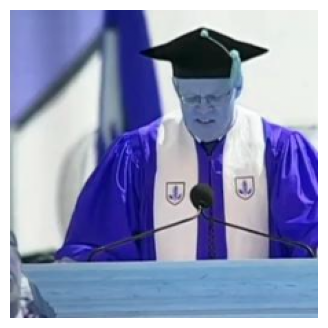

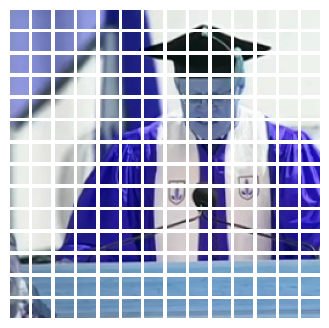

In [171]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img))
    plt.axis("off")

In [109]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [115]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [117]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [127]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_val,y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_val, y_val)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.4879 - loss: 12.0531 - top-5-accuracy: 1.0000 - val_accuracy: 0.5011 - val_loss: 1.9092 - val_top-5-accuracy: 1.0000
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5379 - loss: 2.3535 - top-5-accuracy: 1.0000 - val_accuracy: 0.5011 - val_loss: 1.4470 - val_top-5-accuracy: 1.0000
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.5301 - loss: 1.6864 - top-5-accuracy: 1.0000 - val_accuracy: 0.6256 - val_loss: 0.6341 - val_top-5-accuracy: 1.0000
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5835 - loss: 0.8792 - top-5-accuracy: 1.0000 - val_accuracy: 0.6322 - val_loss: 0.6513 - val_top-5-accuracy: 1.0000
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.6009 - loss: 0.7724 - top-5-accuracy: 1.0000 - val_accuracy: 0.7544 - val_loss: 0.6270 - val_top-5-accuracy: 1.0000
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.6467 - loss: 0.6758 - top-5-accuracy: 1.0000 - 

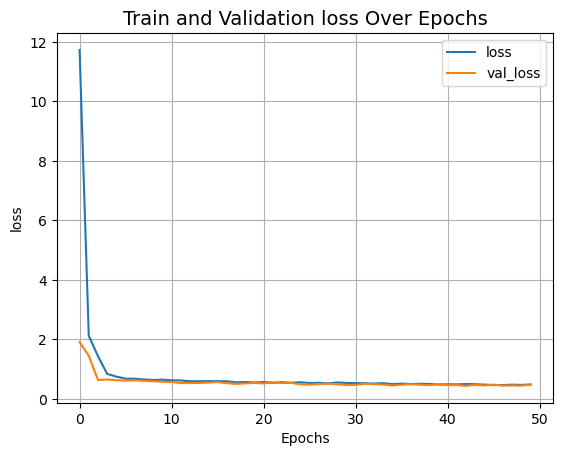

In [165]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")



Accuracy  = 0.790
Val_acc = 0.820

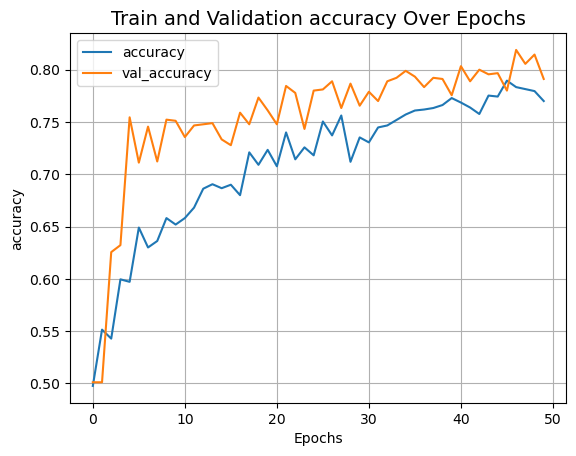

In [167]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("accuracy")



In [183]:
import pandas as pd
history_vit = pd.DataFrame(history.history)
history_vit["epoch"] = history.epoch
history_vit.to_csv("History/ViT History.csv")